C:\Users\L13\AppData\Local\Temp\ipykernel_1492\4098865048.py:11: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_csv('Emission.csv', parse_dates=['Year-Month'], index_col='Year-Month')


Epoch 1/100, Train Loss: 0.2893, Val Loss: 0.7327
Epoch 2/100, Train Loss: 0.2648, Val Loss: 0.6875
Epoch 3/100, Train Loss: 0.2415, Val Loss: 0.6433
Epoch 4/100, Train Loss: 0.2191, Val Loss: 0.5996
Epoch 5/100, Train Loss: 0.1975, Val Loss: 0.5562
Epoch 6/100, Train Loss: 0.1767, Val Loss: 0.5126
Epoch 7/100, Train Loss: 0.1565, Val Loss: 0.4689
Epoch 8/100, Train Loss: 0.1370, Val Loss: 0.4247
Epoch 9/100, Train Loss: 0.1180, Val Loss: 0.3799
Epoch 10/100, Train Loss: 0.0996, Val Loss: 0.3345
Epoch 11/100, Train Loss: 0.0820, Val Loss: 0.2886
Epoch 12/100, Train Loss: 0.0653, Val Loss: 0.2422
Epoch 13/100, Train Loss: 0.0500, Val Loss: 0.1960
Epoch 14/100, Train Loss: 0.0365, Val Loss: 0.1508
Epoch 15/100, Train Loss: 0.0256, Val Loss: 0.1083
Epoch 16/100, Train Loss: 0.0183, Val Loss: 0.0707
Epoch 17/100, Train Loss: 0.0160, Val Loss: 0.0414
Epoch 18/100, Train Loss: 0.0193, Val Loss: 0.0232
Epoch 19/100, Train Loss: 0.0268, Val Loss: 0.0150
Epoch 20/100, Train Loss: 0.0338, Val Lo

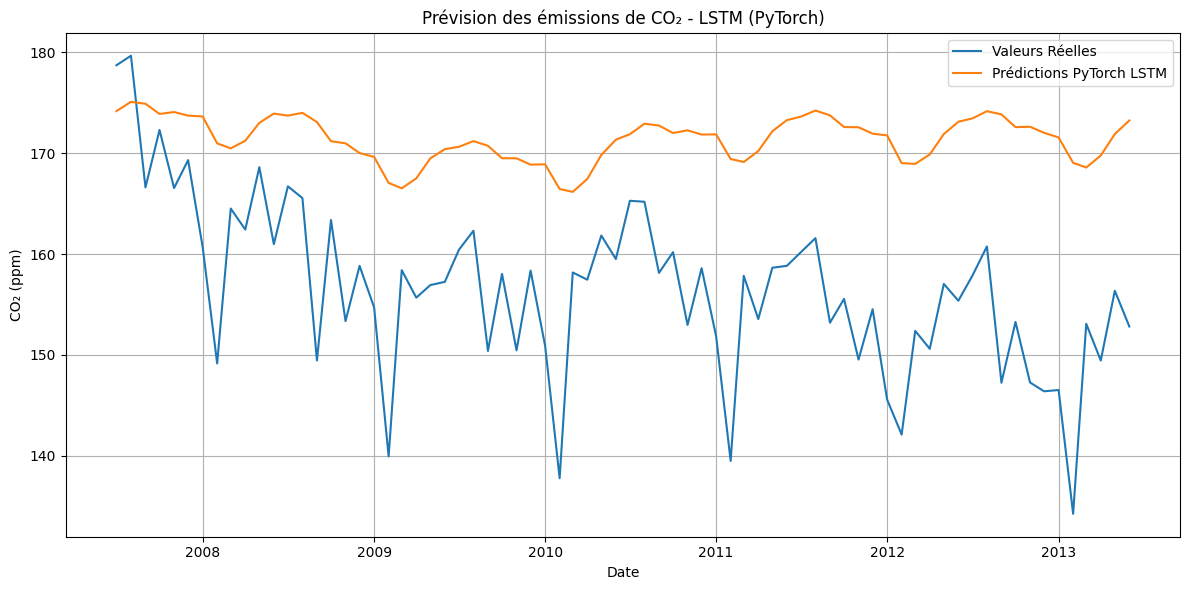

In [4]:
#LSTM via PyTorch 

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

# 1. Chargement et préparation des données
df = pd.read_csv('Emission.csv', parse_dates=['Year-Month'], index_col='Year-Month')
df.columns = ['CO2']
df.sort_index(inplace=True)

# 2. Encodage temporel
df['month'] = df.index.month
df['year'] = df.index.year
df['quarter'] = df.index.quarter
df['sin_month'] = np.sin(2 * np.pi * df['month'] / 12)
df['cos_month'] = np.cos(2 * np.pi * df['month'] / 12)

# 3. Traitement des valeurs manquantes
df['CO2'] = df['CO2'].interpolate(method='time')

# 4. Normalisation
features = ['CO2', 'sin_month', 'cos_month', 'quarter', 'year']
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df[features])
scaled_df = pd.DataFrame(scaled_data, columns=features, index=df.index)

# 5. Création des séquences pour PyTorch
def create_sequences(data, window_size):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i+window_size])
        y.append(data[i+window_size, 0])  # CO2 uniquement
    return np.array(X), np.array(y)

window_size = 12
X, y = create_sequences(scaled_df.values, window_size)

# 6. Split en train/val/test
train_size = int(0.7 * len(X))
val_size = int(0.15 * len(X))

X_train, y_train = X[:train_size], y[:train_size]
X_val, y_val = X[train_size:train_size+val_size], y[train_size:train_size+val_size]
X_test, y_test = X[train_size+val_size:], y[train_size+val_size:]

# 7. Conversion en tenseurs PyTorch
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
X_val = torch.tensor(X_val, dtype=torch.float32)
y_val = torch.tensor(y_val, dtype=torch.float32).view(-1, 1)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

# 8. Définition du modèle LSTM PyTorch
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        output, _ = self.lstm(x)
        last_output = output[:, -1, :]  # On prend la dernière sortie de la séquence
        return self.fc(last_output)

input_size = X_train.shape[2]  # 5 features
hidden_size = 64
output_size = 1

model = LSTMModel(input_size, hidden_size, output_size)

# 9. Définition de la fonction de perte et de l’optimiseur
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# 10. Entraînement du modèle
num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    output = model(X_train)
    loss = criterion(output, y_train)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Validation
    model.eval()
    with torch.no_grad():
        val_output = model(X_val)
        val_loss = criterion(val_output, y_val)

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}")

# 11. Évaluation sur les données de test
model.eval()
with torch.no_grad():
    test_pred = model(X_test)

# 12. Dénormalisation pour interprétation
test_pred_np = test_pred.numpy()
y_test_np = y_test.numpy()

# On doit reconstituer les autres colonnes pour inverse_transform
def recompose(pred, ref):
    return scaler.inverse_transform(np.hstack([pred, ref[:, 1:]]))[:, 0]

y_test_real = recompose(y_test_np, X_test.numpy()[:, -1, :])
y_pred_real = recompose(test_pred_np, X_test.numpy()[:, -1, :])

# 13. Affichage des résultats
plt.figure(figsize=(12, 6))
plt.plot(df.index[-len(y_test_real):], y_test_real, label='Valeurs Réelles')
plt.plot(df.index[-len(y_pred_real):], y_pred_real, label='Prédictions PyTorch LSTM')
plt.title('Prévision des émissions de CO₂ - LSTM (PyTorch)')
plt.xlabel('Date')
plt.ylabel('CO₂ (ppm)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
